In [786]:
import kagglehub
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.optimizers import Adamax, Adam
from tensorflow import keras
from tensorflow.keras import layers,models
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, GlobalMaxPooling2D, Flatten
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


**Download the Data**

In [7]:
# Download latest version
path = kagglehub.dataset_download("anshtanwar/pets-facial-expression-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/jiangying9/.cache/kagglehub/datasets/anshtanwar/pets-facial-expression-dataset/versions/11


In [9]:
path = '/Users/jiangying9/.cache/kagglehub/datasets/anshtanwar/pets-facial-expression-dataset/versions/11'

In [11]:
train_dir = os.path.join(path, "Master Folder/train")
test_dir = os.path.join(path, "Master Folder/test")
val_dir = os.path.join(path, "Master Folder/valid")

In [674]:
def generate_data_paths(data_dir):
    filepaths = []
    labels = []
    valid_extensions = (".jpg", ".jpeg", ".png")  # Ensure only image files are considered

    for folder in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder)
        if not os.path.isdir(folder_path):  # Skip non-directory files
            continue
        
        for file in os.listdir(folder_path):
            if file.lower().endswith(valid_extensions):  # Check for valid images
                filepaths.append(os.path.join(folder_path, file))  # Correct file path storage
                labels.append(folder)  # Assign correct label

    return filepaths, labels

In [676]:
def create_df(filepaths, labels):
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis=1)
    return df

In [680]:
filepaths_train, labels_train = generate_data_paths(train_dir)
filepaths_val, labels_val = generate_data_paths(val_dir)
filepaths_test, labels_test = generate_data_paths(test_dir)

In [686]:
df_train = create_df(filepaths_train, labels_train)
df_val = create_df(filepaths_val, labels_val)
df_test = create_df(filepaths_test, labels_test)

**Data Augmentation**

train_dir = os.path.join(path, "Master Folder/train")
test_dir = os.path.join(path, "Master Folder/test")
val_dir = os.path.join(path, "Master Folder/valid")

In [204]:
train_datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             brightness_range=[0.8,1.2],
                             zoom_range=0.2,
                             shear_range = 0.2,
                             horizontal_flip=True,
                             vertical_flip=True,
                             fill_mode = 'nearest')

In [206]:
datagen = ImageDataGenerator(rescale=1./255)

In [316]:
def generator2(data_dir, datagen, batch_size=32):
    class_dirs = [cls for cls in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, cls))]
    data_generator = datagen.flow_from_directory(
        data_dir,
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode='categorical',
        classes=class_dirs,
        shuffle=True
    )
    return data_generator

In [318]:
def generator(data_dir, datagen, batch_size=32):
    class_dirs = [cls for cls in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, cls))]
    data_generator = datagen.flow_from_directory(
        data_dir,
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode='categorical',
        classes=class_dirs,
        shuffle=False
    )
    return data_generator

In [746]:
train_generator = generator2(train_dir, train_datagen)
train_generator2 =generator2(train_dir, datagen)
val_generator = generator(val_dir, datagen)
test_generator = generator(test_dir, datagen)

Found 1000 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.
Found 36 images belonging to 4 classes.
Found 38 images belonging to 4 classes.


**Basic CNN**

In [748]:
model = Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),  
    layers.Dense(64, activation='relu'), 
    layers.Dense(4, activation='softmax')
])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [750]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_69"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 127008)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_176 (Dense)               │ (None, 64)             │     8,128,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_177 (Dense)               │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,129,732 (31.01 MB)

 Trainable params: 8,129,732 (31.01 MB)

 Non-trainable params: 0 (0.00 B)

In [752]:
history = model.fit(train_generator2, epochs=10, validation_data=val_generator)

Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.2352 - loss: 3.1982 - val_accuracy: 0.1389 - val_loss: 1.4762
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.4745 - loss: 1.1909 - val_accuracy: 0.3056 - val_loss: 1.3939
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.7173 - loss: 0.9153 - val_accuracy: 0.2500 - val_loss: 1.3806
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8253 - loss: 0.6397 - val_accuracy: 0.2778 - val_loss: 1.5298
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8953 - loss: 0.4352 - val_accuracy: 0.4167 - val_loss: 1.3121
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9468 - loss: 0.2765 - val_accuracy: 0.3611 - val_loss: 1.3780
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9876 - loss: 0.1468 - val_accuracy: 0.4167 - val_loss: 1.4182
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9914 - loss: 0.0995 - val_accuracy: 0.3889 - val_loss: 1.

In [754]:
predictions = model.predict(test_generator, batch_size=32)
predicted_classes = np.argmax(predictions, axis=1)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/stepWARNING:tensorflow:6 out of the last 10 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x497ae20c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [756]:
true_classes = test_generator.classes

In [758]:
report = classification_report(true_classes, predicted_classes, target_names=test_generator.class_indices.keys())
print(report)

              precision    recall  f1-score   support

       happy       0.38      0.45      0.42        11
         Sad       0.36      0.36      0.36        11
       Other       0.22      0.33      0.27         6
       Angry       0.20      0.10      0.13        10

    accuracy                           0.32        38
   macro avg       0.29      0.31      0.30        38
weighted avg       0.30      0.32      0.30        38



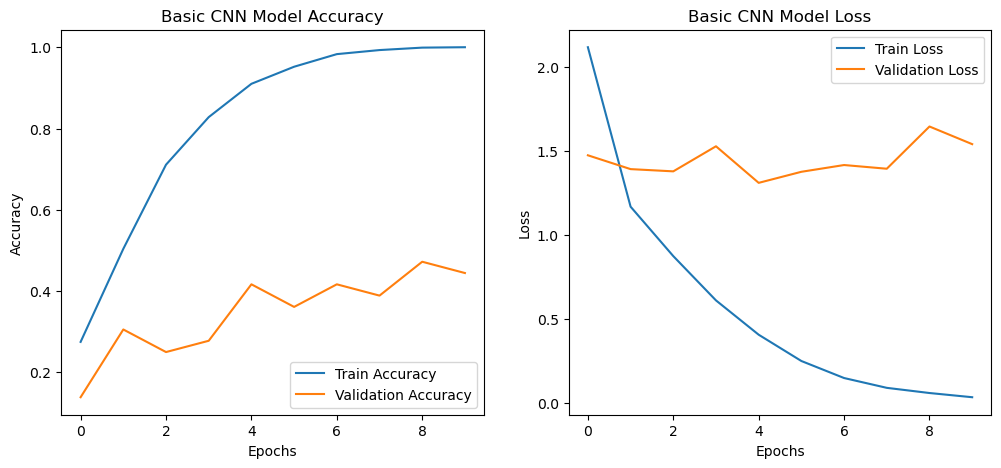

In [760]:
# Plot accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Basic CNN Model Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Basic CNN Model Loss')

plt.show()

The baseline simple CNN consists of a single convolution, a pooling layer, a flattening layer, and two dense layers. It was done as a baseline and it struggles to perform well. The model shows overfitting as the training accuracy goes to 100% quickly, but the validation acccuracy stagnates around 40%, and validation loss does not improve. This suggests the model memorizes the training data, but fails to generalize. This is likely due to the excessive simplicity and insufficient regularization. 

**Complex CNN**

In [856]:
#Define initial model
init_model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    #layers.Conv2D(512, (3, 3), activation='relu'),
    #layers.BatchNormalization(),
    #layers.Conv2D(512, (3, 3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    #layers.Dropout(0.3),
    
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(l2=0.0001)), 
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax') 
])

# Compile initial model
init_model.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Initial model summary
init_model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_81"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 126, 126, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 126, 126, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 124, 124, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_154 (Dropout)           │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 58, 58, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 29, 29, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_155 (Dropout)           │ (None, 29, 29, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 107648)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_207 (Dense)               │ (None, 512)            │    55,116,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_208 (Dense)               │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_156 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_209 (Dense)               │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,443,396 (211.50 MB)

 Trainable params: 55,443,012 (211.50 MB)

 Non-trainable params: 384 (1.50 KB)

In [858]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [860]:
history = init_model.fit(
    train_generator,
    epochs=20,
    batch_size=16,
    validation_data=val_generator,
    callbacks=[early_stopping, lr]
)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 950ms/step - accuracy: 0.2491 - loss: 38.9674 - val_accuracy: 0.2778 - val_loss: 1.4039 - learning_rate: 0.0010
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 888ms/step - accuracy: 0.2350 - loss: 1.4043 - val_accuracy: 0.2778 - val_loss: 1.4027 - learning_rate: 0.0010
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 935ms/step - accuracy: 0.2332 - loss: 1.4039 - val_accuracy: 0.3056 - val_loss: 1.4024 - learning_rate: 0.0010
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 912ms/step - accuracy: 0.2571 - loss: 1.4034 - val_accuracy: 0.2778 - val_loss: 1.4022 - learning_rate: 0.0010
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 913ms/step - accuracy: 0.2416 - loss: 1.4030 - val_accuracy: 0.2778 - val_loss: 1.4016 - learning_rate: 0.0010
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 885ms/step - accuracy: 0.2257 - loss: 1.4029 - val_accuracy: 0.2778 - val_loss: 1.4020 - learning_rate: 0.0010
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 897ms/step - accuracy: 0.2611 - loss: 1

In [862]:
test_loss, test_acc = init_model.evaluate(test_generator,batch_size = 32)
val_loss, val_acc = init_model.evaluate(val_generator,batch_size = 32)

train_loss = history.history['loss'][-1] 
train_acc = history.history['accuracy'][-1]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3076 - loss: 1.4014
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2894 - loss: 1.4015 


In [864]:
# Print results
print(f"Training Accuracy: {train_acc}, Training Loss: {train_loss}")
print(f"Validation Accuracy: {val_acc}, Validation Loss: {val_loss}")
print(f"Test Accuracy: {test_acc}, Test Loss: {test_loss}")

Training Accuracy: 0.25, Training Loss: 1.402075171470642
Validation Accuracy: 0.2777777910232544, Validation Loss: 1.4016203880310059
Test Accuracy: 0.28947368264198303, Test Loss: 1.4016002416610718


In [866]:
predictions = init_model.predict(test_generator, batch_size=32)
predicted_classes = np.argmax(predictions, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


In [868]:
true_classes = test_generator.classes

In [870]:
report = classification_report(true_classes, predicted_classes, target_names=test_generator.class_indices.keys())
print(report)

              precision    recall  f1-score   support

       happy       0.00      0.00      0.00        11
         Sad       0.29      1.00      0.45        11
       Other       0.00      0.00      0.00         6
       Angry       0.00      0.00      0.00        10

    accuracy                           0.29        38
   macro avg       0.07      0.25      0.11        38
weighted avg       0.08      0.29      0.13        38



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


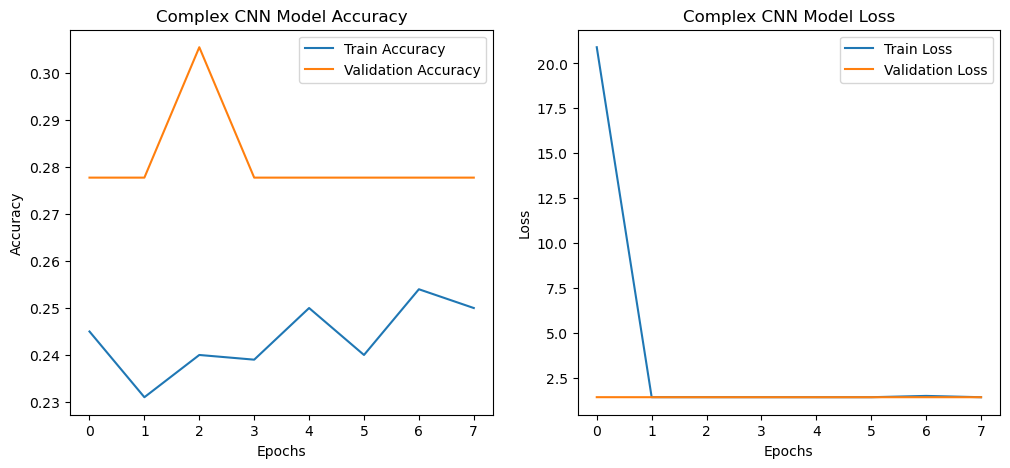

In [872]:
# Plot accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Complex CNN Model Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Complex CNN Model Loss')

plt.show()

We tried to finetune the CNN by building out a more complex CNN model. Although we tried over 20 different parameter combinations, we were unable to find a model that significantly beat the baseline CNN model. The final attempt shown here involves multiple rounds of a combination of Conv2D + BatchNormalization + Conv2D + MaxPooling2D + Dropout. This was done because a combination of convolutional layers for feature extraction, batch normalization for stable training, max pooling for dimensionality reduction, and dropout for regularization. We then flatten, before adding fully connected dense layers with dropout. We implemented early stopping and a learning rate scheduler, which stopped the run after only 8 epochs. The model did not improve over the baseline model. The training and validation accuracy were both under 30%. 

**EfficientNet**

In [828]:
base_model = EfficientNetB5(include_top=False, weights="imagenet", input_shape=(128,128,3), pooling='max')
base_model.trainable = False

for layer in base_model.layers[-70:]:
    layer.trainable = True
# Define Model
eff_model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    Dropout(0.4),
    Dense(4, activation='softmax')
])
# Compile Model
eff_model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
# Show Model Summary
eff_model.summary()

Model: "sequential_80"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb5 (Functional)     │ (None, 2048)           │    28,513,527 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_204 (Dense)               │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_205 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_153 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_206 (Dense)               │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,079,675 (110.93 MB)

 Trainable params: 13,635,528 (52.02 MB)

 Non-trainable params: 15,444,147 (58.91 MB)

In [829]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

In [834]:
history = eff_model.fit(train_generator, epochs=50, validation_data=val_generator)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 411ms/step - accuracy: 0.2846 - loss: 1.6861 - val_accuracy: 0.3333 - val_loss: 1.5762
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 401ms/step - accuracy: 0.2819 - loss: 1.6633 - val_accuracy: 0.3056 - val_loss: 1.6066
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 405ms/step - accuracy: 0.3000 - loss: 1.5898 - val_accuracy: 0.3056 - val_loss: 1.6250
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 378ms/step - accuracy: 0.2515 - loss: 1.6966 - val_accuracy: 0.2222 - val_loss: 1.6050
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 382ms/step - accuracy: 0.2460 - loss: 1.6829 - val_accuracy: 0.2500 - val_loss: 1.5876
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 383ms/step - accuracy: 0.2488 - loss: 1.6674 - val_accuracy: 0.2222 - val_loss: 1.5947
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 376ms/step - accuracy: 0.2436 - loss: 1.7045 - val_accuracy: 0.2500 - val_loss: 1.5505
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 396ms/step - accuracy: 0.2206 - loss: 1.6224 - val_accu

In [885]:
test_loss, test_acc = eff_model.evaluate(test_generator,batch_size = 32)
val_loss, val_acc = eff_model.evaluate(val_generator,batch_size = 32)
train_loss = history.history['loss'][-1] 
train_acc = history.history['accuracy'][-1]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.2516 - loss: 1.3869
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3368 - loss: 1.3766 


In [887]:
# Print results
print(f"Training Accuracy: {train_acc}, Training Loss: {train_loss}")
print(f"Validation Accuracy: {val_acc}, Validation Loss: {val_loss}")
print(f"Test Accuracy: {test_acc}, Test Loss: {test_loss}")

Training Accuracy: 0.460999995470047, Training Loss: 1.6814603805541992
Validation Accuracy: 0.3333333432674408, Validation Loss: 1.3808984756469727
Test Accuracy: 0.2368421107530594, Test Loss: 1.39622163772583


In [889]:
predictions = eff_model.predict(test_generator, batch_size=32)
predicted_classes = np.argmax(predictions, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


In [891]:
true_classes = test_generator.classes

In [893]:
report = classification_report(true_classes, predicted_classes, target_names=test_generator.class_indices.keys())
print(report)

              precision    recall  f1-score   support

       happy       0.29      0.55      0.38        11
         Sad       0.00      0.00      0.00        11
       Other       0.21      0.50      0.30         6
       Angry       0.00      0.00      0.00        10

    accuracy                           0.24        38
   macro avg       0.12      0.26      0.17        38
weighted avg       0.12      0.24      0.16        38



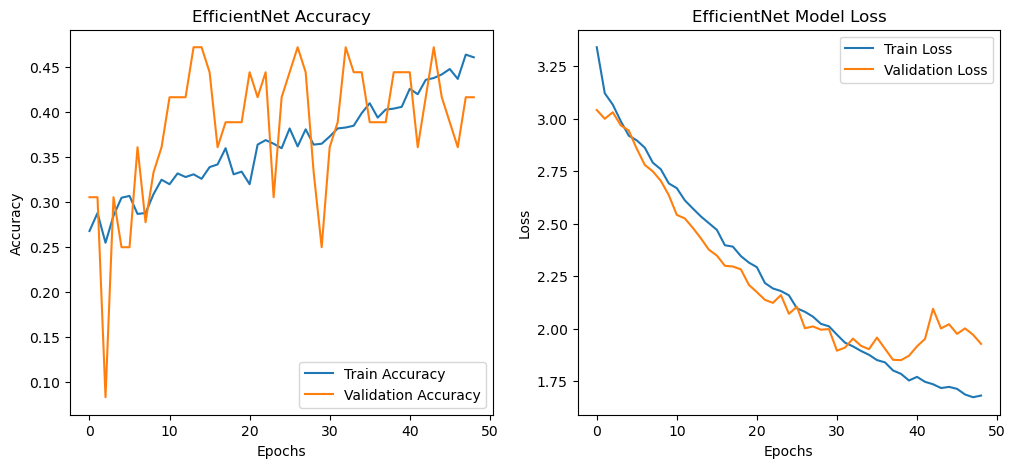

In [895]:
# Plot accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('EfficientNet Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('EfficientNet Model Loss')

plt.show()

EfficientNetB5 with some finetuning customizations. All layers were frozen except for the last 70, and the model was trained over a base model of EfficientNetB5 with batch normalization, dropout, and three dense layers added on top. While the train accuracy trended upward from about 25% to 40%, the validation accuracy was all over the place. The loss steadily decreased for both, however the test performance was very poor. Our dataset is very small, and this model likely overfit the data. Training on a smaller model would be a good next step.   

**MobileNet (Best Model)**

In [664]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

base_model.trainable = True 

for layer in base_model.layers[:-20]:
    layer.trainable = False

# Define Model
model2 = Sequential([
   base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(68, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    Dropout(0.6),
    Dense(4, activation='softmax')
])
# Compile the model
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Print model summary
model2.summary()

Model: "sequential_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_63     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_137 (Dropout)           │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_168 (Dense)               │ (None, 68)             │        87,108 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_138 (Dropout)           │ (None, 68)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_169 (Dense)               │ (None, 4)              │           276 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,345,368 (8.95 MB)

 Trainable params: 1,293,464 (4.93 MB)

 Non-trainable params: 1,051,904 (4.01 MB)

In [666]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

In [668]:
history = model2.fit(train_generator, epochs=100, validation_data=val_generator,callbacks=[early_stopping, lr])

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.2416 - loss: 2.3936 - val_accuracy: 0.1944 - val_loss: 1.8188 - learning_rate: 1.0000e-04
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.3011 - loss: 2.0299 - val_accuracy: 0.2500 - val_loss: 1.6654 - learning_rate: 1.0000e-04
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.3753 - loss: 1.6702 - val_accuracy: 0.3611 - val_loss: 1.5809 - learning_rate: 1.0000e-04
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.3267 - loss: 1.6649 - val_accuracy: 0.3611 - val_loss: 1.5455 - learning_rate: 1.0000e-04
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.3680 - loss: 1.5055 - val_accuracy: 0.3611 - val_loss: 1.5091 - learning_rate: 1.0000e-04
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.4054 - loss: 1.4411 - val_accuracy: 0.3889 - val_loss: 1.4720 - learning_rate: 1.0000e-04
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 

In [670]:
test_loss, test_acc = model2.evaluate(test_generator,batch_size = 32)
val_loss, val_acc = model2.evaluate(val_generator,batch_size = 32)
train_loss = history.history['loss'][-1] 
train_acc = history.history['accuracy'][-1]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5175 - loss: 1.3793
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4606 - loss: 1.3837


In [672]:
# Print results
print(f"Training Accuracy: {train_acc}, Training Loss: {train_loss}")
print(f"Validation Accuracy: {val_acc}, Validation Loss: {val_loss}")
print(f"Test Accuracy: {test_acc}, Test Loss: {test_loss}")

Training Accuracy: 0.6029999852180481, Training Loss: 0.9503428936004639
Validation Accuracy: 0.4722222089767456, Validation Loss: 1.3763877153396606
Test Accuracy: 0.5263158082962036, Test Loss: 1.3635963201522827


In [692]:
predictions = model2.predict(test_generator, batch_size=32)
predicted_classes = np.argmax(predictions, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step 


In [694]:
true_classes = test_generator.classes

In [700]:
report = classification_report(true_classes, predicted_classes, target_names=test_generator.class_indices.keys())
print(report)

              precision    recall  f1-score   support

       happy       1.00      0.36      0.53        11
         Sad       0.50      0.64      0.56        11
       Other       0.20      0.17      0.18         6
       Angry       0.53      0.80      0.64        10

    accuracy                           0.53        38
   macro avg       0.56      0.49      0.48        38
weighted avg       0.61      0.53      0.51        38



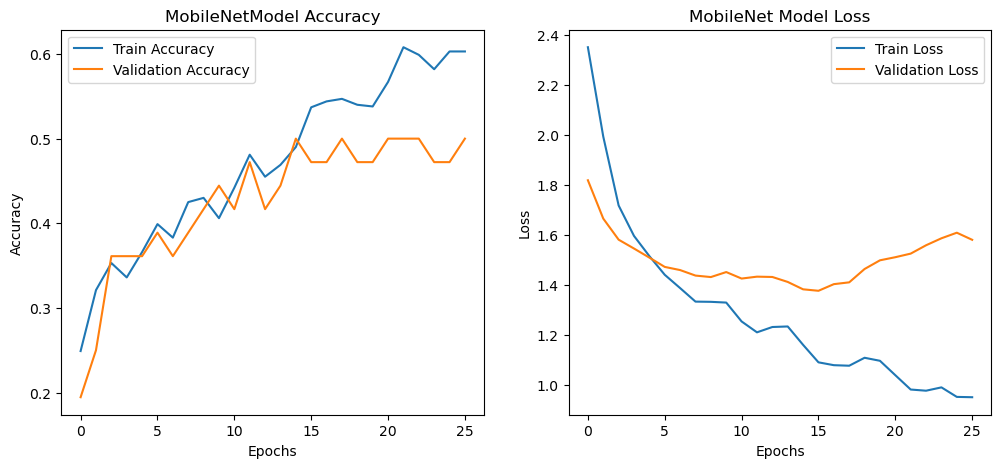

In [704]:
# Plot accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('MobileNetModel Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('MobileNet Model Loss')

plt.show()

MobileNetV2 with some finetuning customizations. All layers were frozen except for the last 20, and the model was trained over a base model of MobileNetV2 with global pooling, two dropout layers, and two dense layers added on top. Both the train and validation accuracy trended upward, with the training accuracy moving from about 25% to 60% and the validation accuracy moving from 20% to 50%. The loss steadily decreased for the train, while a subtle loss was seen in the validation. However, the test performance was the best so far at 56%. Our dataset is very small, and the fact that MobileNetV2 is also small helped in preventing some of the overfitting seen in other models. 

**ResNet 50**

In [920]:
# Load ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
 
base_model.trainable = True
for layer in base_model.layers[:-50]:  # Freezing all but the last few layers
    layer.trainable = False

x = base_model.output 
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x) 
x = Dropout(0.5)(x)
x = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(l2=0.01))(x) 
x = Dropout(0.5)(x)
output_layer = Dense(4, activation='softmax')(x)

# Create the final model
model3 = Model(inputs=base_model.input, outputs=output_layer)
               
# Compile the model
model3.compile(optimizer=Adam(learning_rate=1e-4, decay=1e-3),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Learning rate scheduler (Reduce LR on Plateau)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [922]:
history = model3.fit(train_generator, 
                    epochs=50, 
                    validation_data=val_generator, 
                    callbacks=[early_stopping,lr_scheduler])

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 480ms/step - accuracy: 0.2568 - loss: 3.2597 - val_accuracy: 0.3056 - val_loss: 3.0287 - learning_rate: 1.0000e-04
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 426ms/step - accuracy: 0.2481 - loss: 3.0766 - val_accuracy: 0.3056 - val_loss: 2.9626 - learning_rate: 1.0000e-04
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 434ms/step - accuracy: 0.2512 - loss: 2.9623 - val_accuracy: 0.1944 - val_loss: 2.9057 - learning_rate: 1.0000e-04
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 464ms/step - accuracy: 0.2781 - loss: 2.8972 - val_accuracy: 0.1667 - val_loss: 2.8355 - learning_rate: 1.0000e-04
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 466ms/step - accuracy: 0.2249 - loss: 2.8321 - val_accuracy: 0.3056 - val_loss: 2.7565 - learning_rate: 1.0000e-04
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 589ms/step - accuracy: 0.2852 - loss: 2.7576 - val_accuracy: 0.2500 - val_loss: 2.6995 - learning_rate: 1.0000e-04
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 519ms/step - acc

In [924]:
test_loss, test_acc = model3.evaluate(test_generator,batch_size = 32)
val_loss, val_acc = model3.evaluate(val_generator,batch_size = 32)
train_loss = history.history['loss'][-1] 
train_acc = history.history['accuracy'][-1]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.2939 - loss: 1.5280
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4028 - loss: 1.4606 


In [926]:
# Print results
print(f"Training Accuracy: {train_acc}, Training Loss: {train_loss}")
print(f"Validation Accuracy: {val_acc}, Validation Loss: {val_loss}")
print(f"Test Accuracy: {test_acc}, Test Loss: {test_loss}")

Training Accuracy: 0.3230000138282776, Training Loss: 1.4906398057937622
Validation Accuracy: 0.4166666567325592, Validation Loss: 1.4522576332092285
Test Accuracy: 0.31578946113586426, Test Loss: 1.5224964618682861


In [928]:
predictions = model3.predict(test_generator, batch_size=32)
predicted_classes = np.argmax(predictions, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 824ms/step


In [930]:
true_classes = test_generator.classes

In [932]:
report = classification_report(true_classes, predicted_classes, target_names=test_generator.class_indices.keys())
print(report)

              precision    recall  f1-score   support

       happy       0.30      0.27      0.29        11
         Sad       0.33      0.09      0.14        11
       Other       0.00      0.00      0.00         6
       Angry       0.32      0.80      0.46        10

    accuracy                           0.32        38
   macro avg       0.24      0.29      0.22        38
weighted avg       0.27      0.32      0.24        38



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


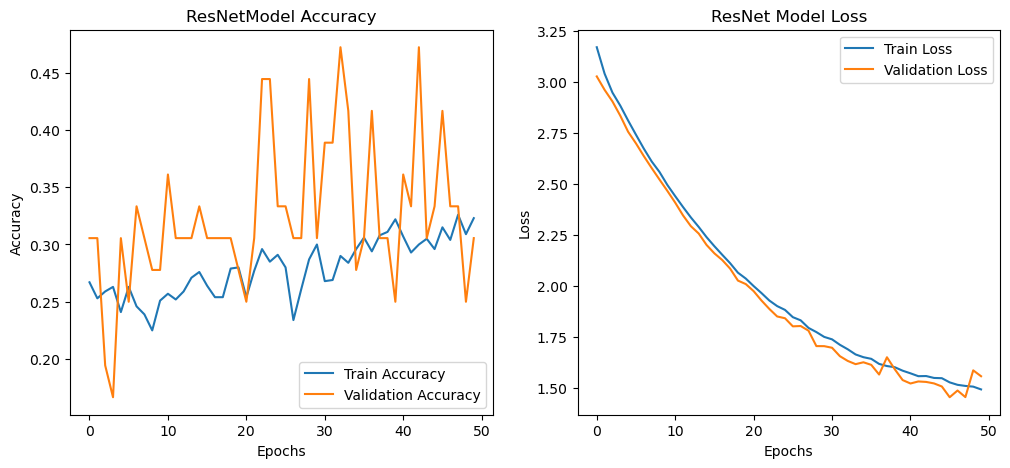

In [934]:
# Plot accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('ResNetModel Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('ResNet Model Loss')

plt.show()

ResNet50 with some finetuning customizations. All layers were frozen except for the last 50, and the model was trained over a base model of ResNet50 with global pooling, two dropout layers, and two dense layers added on top. The train accuracy remained steady at around 25-30% and the validation accuracy was jumping up and down between 30 and 45%. The loss steadily decreased for both. However, the test performance did not improve over the base CNN model at just 24%. Our dataset is very small, and the fact that ResNet50 is so large might have led to some overfitting that was also seen in other models.